I need to write this notebook as proper classes in .py files and call function for vizualization in the notebook

In [1]:
import cv2
import mediapipe as mp
import time
import math
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

# Define Enum for specific keypoints (shoulders and hips)
class Keypoints(Enum):
    LEFT_SHOULDER = 11
    RIGHT_SHOULDER = 12
    LEFT_WRIST = 15
    RIGHT_WRIST = 16

class poseDetector():
    def __init__(self, mode=False, upBody=True, smooth=True,
                 detectionCon=0.5, trackCon=0.5):
        self.mode = mode
        self.upBody = upBody
        self.smooth = smooth
        self.detectionCon = detectionCon
        self.trackCon = trackCon
        self.mpDraw = mp.solutions.drawing_utils
        self.mpPose = mp.solutions.pose
        
        # Pose constructor
        self.pose = self.mpPose.Pose(
            static_image_mode=self.mode,
            model_complexity=1,
            smooth_landmarks=self.smooth,
            enable_segmentation=False,
            min_detection_confidence=self.detectionCon,
            min_tracking_confidence=self.trackCon
        )
        
        # List to store midpoints between hips
        self.midpoints = []
        self.midpoints_y_values = []
        
    def findPose(self, img, draw=True):
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.pose.process(imgRGB)
        
        return img

    def findPosition(self, img, draw=True):
        lmList = []
        if self.results.pose_landmarks:
            for id, lm in enumerate(self.results.pose_landmarks.landmark):
                h, w, c = img.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                visibility = lm.visibility
                lmList.append([id, cx, cy, visibility])

        # Only return and print the keypoints of interest (shoulders and hips)
        if draw:
            keypoints = [Keypoints.LEFT_SHOULDER, Keypoints.RIGHT_SHOULDER, Keypoints.LEFT_WRIST, Keypoints.RIGHT_WRIST]
            points = {}

            for keypoint in keypoints:
                id = keypoint.value
                cx, cy = lmList[id][1], lmList[id][2]
                visibility = lmList[id][3]
                points[keypoint] = (cx, cy, visibility)
                
                # Draw the keypoints
                cv2.circle(img, (cx, cy), 10, (0, 255, 0), cv2.FILLED)
                cv2.putText(img, f'{keypoint.name}', (cx + 10, cy + 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0), 2)
                
                # Print x, y, and visibility for the keypoints
                #!print(f'{keypoint.name} - X: {cx}, Y: {cy}, Visibility: {visibility}')

            # Draw connections between the keypoints (shoulders and hips)
            cv2.line(img, points[Keypoints.LEFT_SHOULDER][:2], points[Keypoints.LEFT_WRIST][:2], (255, 0, 0), 2)
            cv2.line(img, points[Keypoints.RIGHT_SHOULDER][:2], points[Keypoints.RIGHT_WRIST][:2], (255, 0, 0), 2)
            cv2.line(img, points[Keypoints.LEFT_SHOULDER][:2], points[Keypoints.RIGHT_SHOULDER][:2], (255, 0, 0), 2)
            cv2.line(img, points[Keypoints.LEFT_WRIST][:2], points[Keypoints.RIGHT_WRIST][:2], (255, 0, 0), 2)

            # Calculate the midpoint between the two hips
            left_wrist = points[Keypoints.LEFT_WRIST][:2]
            right_wrist = points[Keypoints.RIGHT_WRIST][:2]
            midpoint = ((left_wrist[0] + right_wrist[0]) // 2, (left_wrist[1] + right_wrist[1]) // 2)
            midpoints_y_value = (left_wrist[1] + right_wrist[1]) // 2
            
            # Append the midpoint to the midpoints list
            self.midpoints.append(midpoint)
            self.midpoints_y_values.append(midpoints_y_value)


            
            # Draw the midpoint
            cv2.circle(img, midpoint, 10, (255, 255, 0), cv2.FILLED)
            cv2.putText(img, 'Midpoint', (midpoint[0] + 10, midpoint[1] + 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 0), 2)

        return lmList

    def findAngle(self, img, p1, p2, p3, draw=True):
        x1, y1 = self.lmList[p1][1:3]
        x2, y2 = self.lmList[p2][1:3]
        x3, y3 = self.lmList[p3][1:3]
        
        angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - 
                             math.atan2(y1 - y2, x1 - x2))
        if angle < 0:
            angle += 360
        
        if draw:
            cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 3)
            cv2.line(img, (x3, y3), (x2, y2), (255, 255, 255), 3)
            cv2.circle(img, (x1, y1), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x1, y1), 15, (0, 0, 255), 2)
            cv2.circle(img, (x2, y2), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x2, y2), 15, (0, 0, 255), 2)
            cv2.circle(img, (x3, y3), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x3, y3), 15, (0, 0, 255), 2)
            cv2.putText(img, str(int(angle)), (x2 - 50, y2 + 50),
                        cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
        return angle
    
    #Function that uses the list of midpoints to draw a curve over a certain number of frames (list size) using matplotlib
    def drawCurve(self):
        import matplotlib.pyplot as plt

        # Extract y coordinates from midpoints
        y_coords = [point[1] for point in self.midpoints]
        x_coords = list(range(len(y_coords)))  # Use the index as x coordinates

        # Plot the curve
        plt.figure(figsize=(10, 5))
        plt.plot(x_coords, y_coords, marker='o', color='b')
        plt.title('Midpoint Curve')
        plt.xlabel('Frame Index')
        plt.ylabel('Y Coordinates')
        plt.grid(True)
        plt.show()

    # Draw the curve of midpoints and draw on the same plot the reference curve
    def drawCurveWithReference(self, peaks, smoothed_y):
        # Extract y coordinates from midpoints
        y_coords = [point[1] for point in self.midpoints]
        x_coords = list(range(len(y_coords)))  # Use the index as x coordinates

        # Plot the curve
        plt.figure(figsize=(10, 5))
        plt.plot(x_coords, y_coords, color='red', label='Midpoint Curve')
        plt.plot(smoothed_y, label="Smoothed Motion", color="blue", linewidth=2)
        plt.plot(peaks, smoothed_y[peaks], "x", color="green", label='Reference Curve')
        plt.title('Midpoint Curve')
        plt.xlabel('Frame Index')
        plt.ylabel('Y Coordinates')
        plt.grid(True)
        plt.legend()
        plt.show()
    


Preparing for ball (Ground Truth) detection

In [13]:

lower_orange = np.array([5, 120, 120])  
upper_orange = np.array([25, 255, 255])  
y_positions = []  

sum_r = 0
avg_r = 0


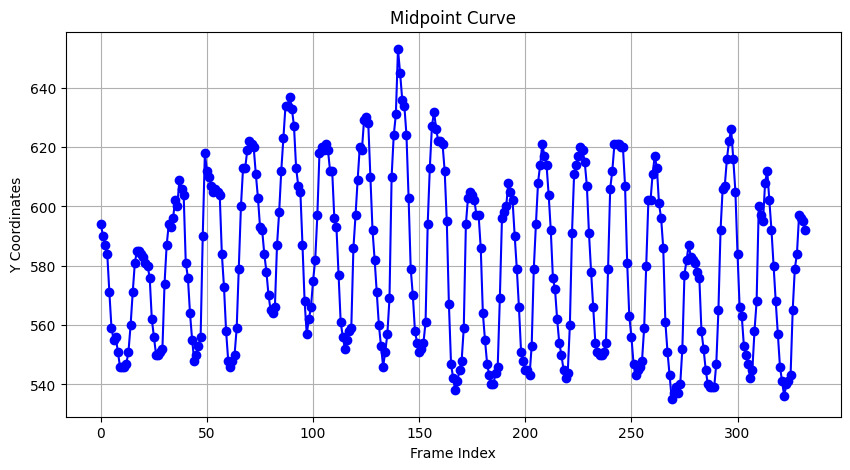

(194, 590)


: 

In [ ]:
cap = cv2.VideoCapture("cropped.mp4")
pTime = 0
detector = poseDetector()
frames = []

while True:
    success, img = cap.read()
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    if not success:
        break
    
    img = detector.findPose(img)
    detector.findPosition(img)
    frames.append(img)

    # Display FPS
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    cv2.putText(img, str(int(fps)), (70, 50), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0), 3)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_orange, upper_orange)
    gray = cv2.GaussianBlur(cv2.bitwise_and(img, img, mask=mask), (9, 9), 2)
    gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)


    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1.2, 30, param1=50, param2=30, minRadius=5, maxRadius=50)

    if circles is not None:
        x, y, r = min(circles[0], key=lambda c: c[2])  
        y_positions.append(y)  
        sum_r += r

        # Draw detected ball
        cv2.circle(img, (int(x), int(y)), int(r), (0, 255, 0), 2)
        cv2.circle(img, (int(x), int(y)), 2, (0, 0, 255), 3)
    
    cv2.imshow("Motion Curve Tracking", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
# Draw the curve
detector.drawCurve()

print(detector.midpoints[1])

In [20]:
# Calculate pixel to cm ratio
RADIUS_CM = 2

avg_r = sum_r / len(y_positions)
print(f"The average radius is {avg_r} pixels")

pixel_to_cm = RADIUS_CM / avg_r
print(f"The pixel to cm ratio is {pixel_to_cm} cm/pixel")

The average radius is 17.072157348682676 pixels
The pixel to cm ratio is 0.11714981060400806 cm/pixel


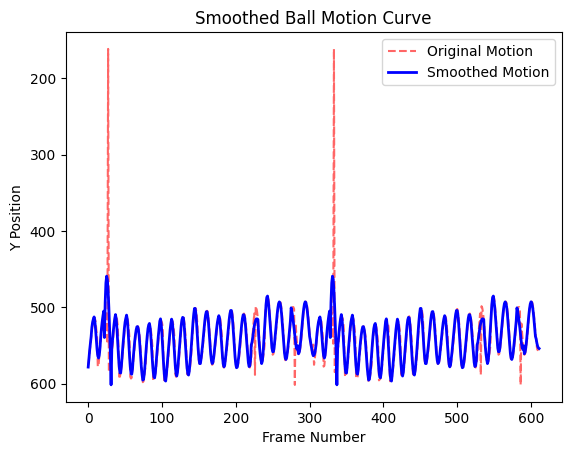

In [21]:
# Apply Savitzky-Golay filter for smoothing
if len(y_positions) > 5:  # Ensure enough data points for filtering
    smoothed_y = savgol_filter(y_positions, window_length=10, polyorder=2)
else:
    smoothed_y = y_positions  # Fallback if not enough points

# Plot motion curve
plt.plot(y_positions, label="Original Motion", color="red", linestyle="dashed", alpha=0.6)
plt.plot(smoothed_y, label="Smoothed Motion", color="blue", linewidth=2)
plt.xlabel("Frame Number")
plt.ylabel("Y Position")
plt.title("Smoothed Ball Motion Curve")
plt.legend()
plt.gca().invert_yaxis()  # Invert Y-axis (since top is 0 in images)
plt.show()

In [22]:
print(detector.midpoints_y_values)
print(smoothed_y )

[594, 590, 587, 584, 571, 559, 555, 556, 551, 546, 546, 546, 547, 551, 560, 571, 581, 585, 585, 584, 583, 581, 580, 576, 562, 556, 550, 550, 551, 552, 574, 587, 594, 593, 596, 602, 600, 609, 606, 604, 581, 576, 564, 555, 548, 550, 553, 556, 590, 618, 612, 610, 607, 605, 606, 605, 604, 584, 573, 558, 548, 546, 548, 550, 559, 579, 600, 613, 613, 619, 622, 621, 620, 611, 603, 593, 592, 584, 578, 570, 565, 564, 566, 587, 598, 612, 623, 634, 634, 637, 633, 627, 613, 607, 605, 587, 568, 557, 562, 566, 575, 582, 597, 618, 620, 619, 621, 619, 612, 612, 596, 593, 577, 561, 556, 552, 555, 558, 559, 586, 597, 609, 620, 619, 629, 630, 628, 610, 592, 582, 571, 560, 553, 546, 551, 557, 569, 610, 624, 631, 653, 645, 636, 634, 624, 603, 579, 570, 558, 554, 551, 552, 554, 561, 594, 613, 627, 632, 626, 622, 622, 621, 612, 595, 567, 547, 542, 538, 541, 545, 548, 559, 594, 603, 605, 604, 602, 597, 597, 586, 564, 555, 547, 543, 540, 540, 544, 546, 569, 596, 598, 600, 608, 605, 602, 590, 579, 566, 551, 548,

In [23]:
# Find peaks (local maxima) in the smoothed signal
peaks_max = find_peaks(-smoothed_y, distance=10)  # Negative because higher y is downward
peaks_min = find_peaks(smoothed_y, distance=10) 
peaks = np.sort(np.concatenate((peaks_max[0], peaks_min[0])))

detector.midpoints_y_values = np.array(detector.midpoints_y_values)
# Find peaks in reference signal
peaks_max_ref = find_peaks(detector.midpoints_y_values, distance=10)  
peaks_min_ref = find_peaks(-detector.midpoints_y_values, distance=10)
peaks_ref = np.sort(np.concatenate((peaks_max_ref[0], peaks_min_ref[0])))

# Calculate motion frequency (rate)
if len(peaks_max[0]) > 1:
    # peak_to_peak_frames contains the difference in frame numbers between 2 conesecutive peaks
    peak_to_peak_frames = np.diff(peaks_max[0])  # Time between peaks in frames
    avg_peak_to_peak_frames = np.mean(peak_to_peak_frames)  # Average period in frames
    avg_period_seconds = avg_peak_to_peak_frames / fps  # Convert to seconds
    frequency_hz = 1 / avg_period_seconds  # Convert period to frequency
else:
    frequency_hz = None
    avg_peak_to_peak_frames = None

# Calculate depth of motion (peak-to-peak distance)
if len(peaks) > 1:
    compression_depth_px = np.diff(smoothed_y[peaks])  # Distance between peaks in pixels
    compression_depth_px = np.abs(compression_depth_px)
    avg_compression_depth_px= np.mean(compression_depth_px)  # Average depth in pixels
    avg_compression_depth_cm = avg_compression_depth_px * pixel_to_cm  # Convert to cm  

#Calculate depth using array of midpoints in detector class
if len(peaks_ref) > 1:
    compression_depth_ref = np.diff(detector.midpoints_y_values[peaks_ref])  # Distance between peaks in pixels
    compression_depth_ref = np.abs(compression_depth_ref)
    avg_compression_depth_ref = np.mean(compression_depth_ref)  # Average depth in pixels
    avg_compression_depth_cm_ref = avg_compression_depth_ref * pixel_to_cm  # Convert to cm

#Print the extracted values of the reference curve
#print(f"Motion Frequency (Reference): {frequency_hz:.2f} Hz" if frequency_hz else "Not enough peaks detected")
print(f"Average Compression Depth (Midpoint): {avg_compression_depth_cm_ref:.2f} cm" if avg_compression_depth_cm_ref else "Not enough peaks detected")


# Print extracted values
print(f"Motion Frequency: {frequency_hz:.2f} Hz" if frequency_hz else "Not enough peaks detected")
print(f"Average Compression Depth (Reference): {avg_compression_depth_cm:.2f} cm" if avg_compression_depth_cm else "Not enough peaks detected")

Average Compression Depth (Midpoint): 8.22 cm
Motion Frequency: 1.28 Hz
Average Compression Depth (Reference): 8.75 cm


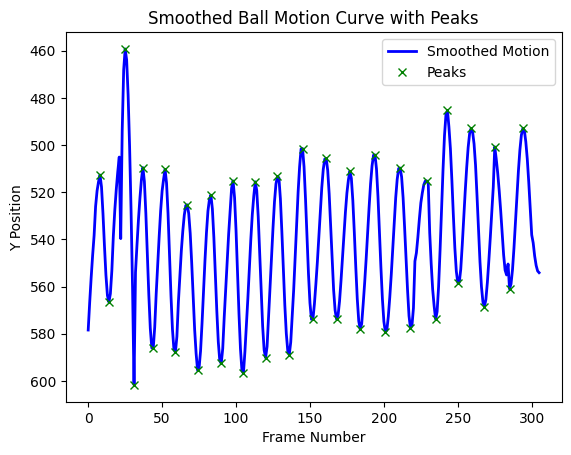

In [75]:
# Plot the peaks on the motion curve
plt.plot(smoothed_y, label="Smoothed Motion", color="blue", linewidth=2)
plt.plot(peaks, smoothed_y[peaks], "x", label="Peaks", color="green")
plt.xlabel("Frame Number")
plt.ylabel("Y Position")
plt.title("Smoothed Ball Motion Curve with Peaks")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

Display Ground Truth Vs Proposed Technique

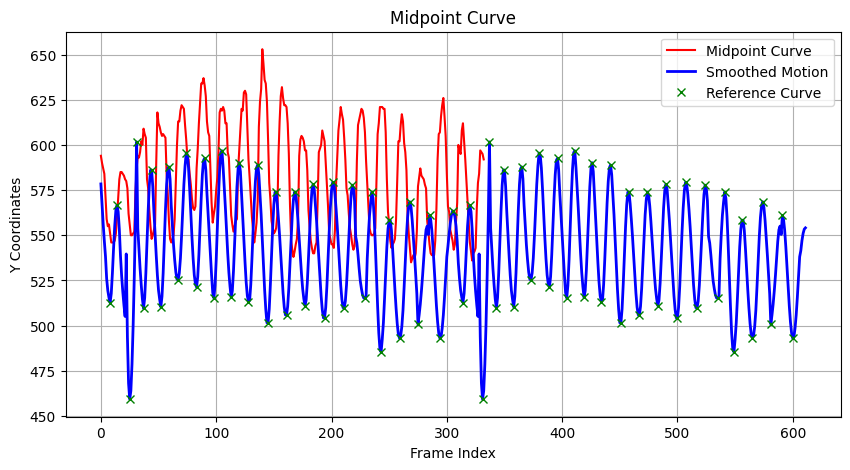

In [24]:
# Draw the 2 curves above on the same plot
detector.drawCurveWithReference(peaks, smoothed_y)